## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 8s 39ms/step - los

Epoch 1/10
196/196 [==============================] - 8s 41ms/step - loss: 198.7010 - accuracy: 0.2305 - val_loss: 41.1256 - val_accuracy: 0.2327
Epoch 2/10
196/196 [==============================] - 8s 43ms/step - loss: 19.1163 - accuracy: 0.1142 - val_loss: 7.2905 - val_accuracy: 0.1000
Epoch 3/10
196/196 [==============================] - 9s 44ms/step - loss: 4.1154 - accuracy: 0.0996 - val_loss: 2.6482 - val_accuracy: 0.1000
Epoch 4/10
196/196 [==============================] - 9s 45ms/step - loss: 2.4857 - accuracy: 0.0966 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 5/10
196/196 [==============================] - 8s 43ms/step - loss: 2.4626 - accuracy: 0.0958 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 6/10
196/196 [==============================] - 8s 41ms/step - loss: 2.4626 - accuracy: 0.0965 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 7/10
196/196 [==============================] - 8s 41ms/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4625 - val_accuracy: 0.

Epoch 6/10
196/196 [==============================] - 7s 38ms/step - loss: 5.3406 - accuracy: 0.4461 - val_loss: 5.3037 - val_accuracy: 0.4473
Epoch 7/10
196/196 [==============================] - 7s 38ms/step - loss: 5.2416 - accuracy: 0.4582 - val_loss: 5.2185 - val_accuracy: 0.4532
Epoch 8/10
196/196 [==============================] - 8s 42ms/step - loss: 5.1485 - accuracy: 0.4666 - val_loss: 5.1206 - val_accuracy: 0.4656
Epoch 9/10
196/196 [==============================] - 9s 44ms/step - loss: 5.0556 - accuracy: 0.4755 - val_loss: 5.0380 - val_accuracy: 0.4639
Epoch 10/10
196/196 [==============================] - 8s 43ms/step - loss: 4.9683 - accuracy: 0.4837 - val_loss: 4.9759 - val_accuracy: 0.4620
Experiment with L1 = 0.000100, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
__________________________

Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 7s 36ms/step - los

Epoch 1/10
196/196 [==============================] - 8s 40ms/step - loss: 2.0079 - accuracy: 0.2783 - val_loss: 1.8458 - val_accuracy: 0.3526
Epoch 2/10
196/196 [==============================] - 8s 40ms/step - loss: 1.7871 - accuracy: 0.3703 - val_loss: 1.7319 - val_accuracy: 0.3974
Epoch 3/10
196/196 [==============================] - 8s 40ms/step - loss: 1.7032 - accuracy: 0.4000 - val_loss: 1.6761 - val_accuracy: 0.4166
Epoch 4/10
196/196 [==============================] - 8s 41ms/step - loss: 1.6444 - accuracy: 0.4243 - val_loss: 1.6289 - val_accuracy: 0.4287
Epoch 5/10
196/196 [==============================] - 8s 40ms/step - loss: 1.5976 - accuracy: 0.4381 - val_loss: 1.5839 - val_accuracy: 0.4436
Epoch 6/10
196/196 [==============================] - 8s 42ms/step - loss: 1.5597 - accuracy: 0.4537 - val_loss: 1.5542 - val_accuracy: 0.4540
Epoch 7/10
196/196 [==============================] - 8s 41ms/step - loss: 1.5257 - accuracy: 0.4631 - val_loss: 1.5531 - val_accuracy: 0.4527

Epoch 6/10
196/196 [==============================] - 13s 64ms/step - loss: 1.7103 - accuracy: 0.4482 - val_loss: 1.7221 - val_accuracy: 0.4426
Epoch 7/10
196/196 [==============================] - 14s 74ms/step - loss: 1.6764 - accuracy: 0.4611 - val_loss: 1.6800 - val_accuracy: 0.4574
Epoch 8/10
196/196 [==============================] - 13s 69ms/step - loss: 1.6470 - accuracy: 0.4704 - val_loss: 1.6558 - val_accuracy: 0.4647
Epoch 9/10
196/196 [==============================] - 12s 60ms/step - loss: 1.6190 - accuracy: 0.4813 - val_loss: 1.6335 - val_accuracy: 0.4696
Epoch 10/10
196/196 [==============================] - 19s 96ms/step - loss: 1.5933 - accuracy: 0.4894 - val_loss: 1.6223 - val_accuracy: 0.4720
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_____________________

Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 7s 34ms/step - los

Epoch 1/10
196/196 [==============================] - 7s 37ms/step - loss: 2.0227 - accuracy: 0.2753 - val_loss: 1.8707 - val_accuracy: 0.3378
Epoch 2/10
196/196 [==============================] - 6s 30ms/step - loss: 1.8082 - accuracy: 0.3637 - val_loss: 1.7574 - val_accuracy: 0.3814
Epoch 3/10
196/196 [==============================] - 6s 31ms/step - loss: 1.7249 - accuracy: 0.3959 - val_loss: 1.6889 - val_accuracy: 0.4027
Epoch 4/10
196/196 [==============================] - 6s 30ms/step - loss: 1.6682 - accuracy: 0.4134 - val_loss: 1.6442 - val_accuracy: 0.4208
Epoch 5/10
196/196 [==============================] - 6s 30ms/step - loss: 1.6201 - accuracy: 0.4325 - val_loss: 1.6094 - val_accuracy: 0.4338
Epoch 6/10
196/196 [==============================] - 6s 31ms/step - loss: 1.5789 - accuracy: 0.4492 - val_loss: 1.5742 - val_accuracy: 0.4429
Epoch 7/10
196/196 [==============================] - 6s 31ms/step - loss: 1.5452 - accuracy: 0.4593 - val_loss: 1.5465 - val_accuracy: 0.4543

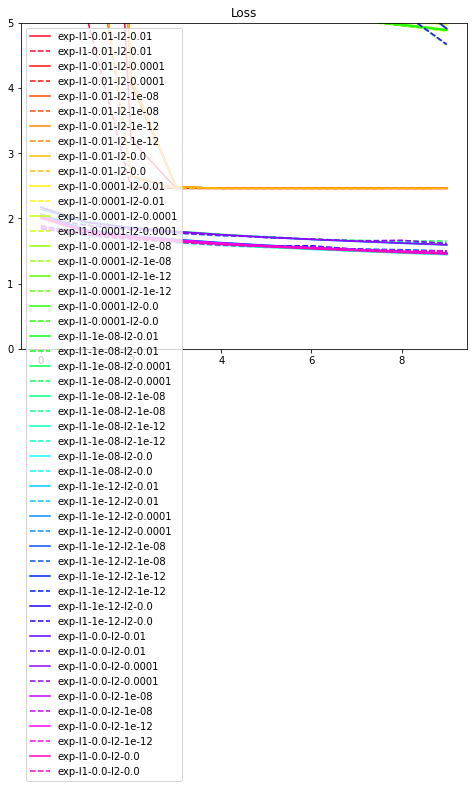

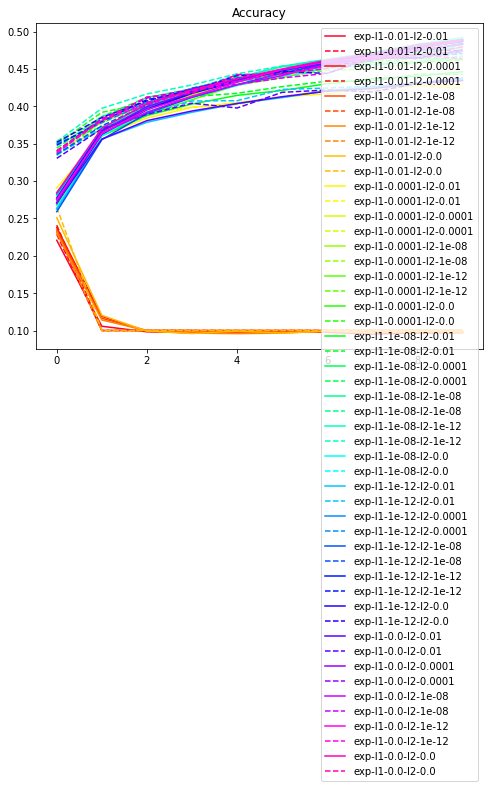

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()